

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol
/Users/jpierel/DataBase/HST/psfs/PSFSTD_WFC3UV_F814W.fits
Using PSF file PSFSTD_WFC3UV_F814W.fits
254.6870255481229 255.66244104159586


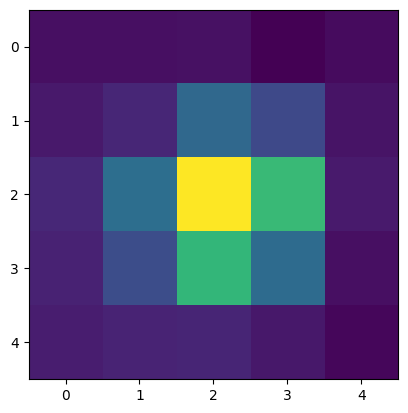

250.05069819362694 250.9814775384698


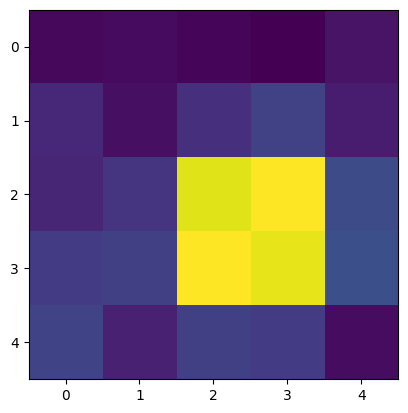

252.3689396762377 253.32203705670904


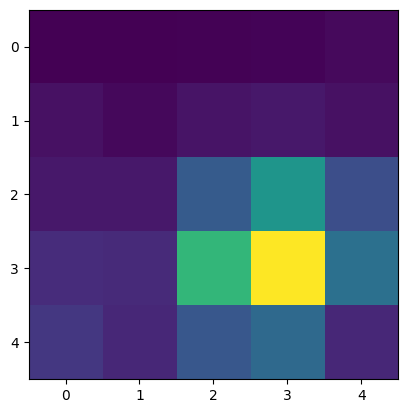

{'flux': array([  0.        , 156.68933868]), 'x0': array([253.68702555, 255.68702555]), 'y0': array([254.66244104, 256.66244104]), 'x1': array([249.05069819, 251.05069819]), 'y1': array([249.98147754, 251.98147754]), 'x2': array([251.36893968, 253.36893968]), 'y2': array([252.32203706, 254.32203706]), 'bkg': [0, 1]}
[245, 247] [266, 268]
/Users/jpierel/DataBase/HST/psfs/PSFSTD_WFC3UV_F814W.fits
Using PSF file PSFSTD_WFC3UV_F814W.fits
[241, 242] [262, 263]
/Users/jpierel/DataBase/HST/psfs/PSFSTD_WFC3UV_F814W.fits
Using PSF file PSFSTD_WFC3UV_F814W.fits
[243, 244] [264, 265]
/Users/jpierel/DataBase/HST/psfs/PSFSTD_WFC3UV_F814W.fits
Using PSF file PSFSTD_WFC3UV_F814W.fits
Finished PSF psf_photometry with median residuals of 1.53%


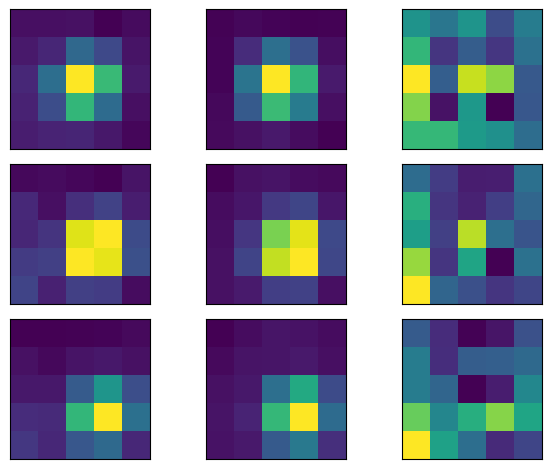

        ra                 ra_err                dec                dec_err         ...        mag                magerr        zpsys        exp        
------------------ ---------------------- ------------------ ---------------------- ... ------------------ -------------------- ----- ------------------
  263.934724388871 2.8553449737955816e-07  4.832467794728589 2.6410422293565716e-08 ... 20.667877324840806 0.013451367580118917    ab iebc16ubq_flc.fits
263.93472417390194 2.6879854431172134e-07 4.8324679665511585 2.8560599218963034e-08 ...  20.66802854386871 0.013451368727542564    ab iebc16u5q_flc.fits
  263.934724606147 2.9331874884519493e-07  4.832467185794666 3.5399344788800136e-08 ... 20.668005278246284 0.013451368550986276    ab iebc16u8q_flc.fits


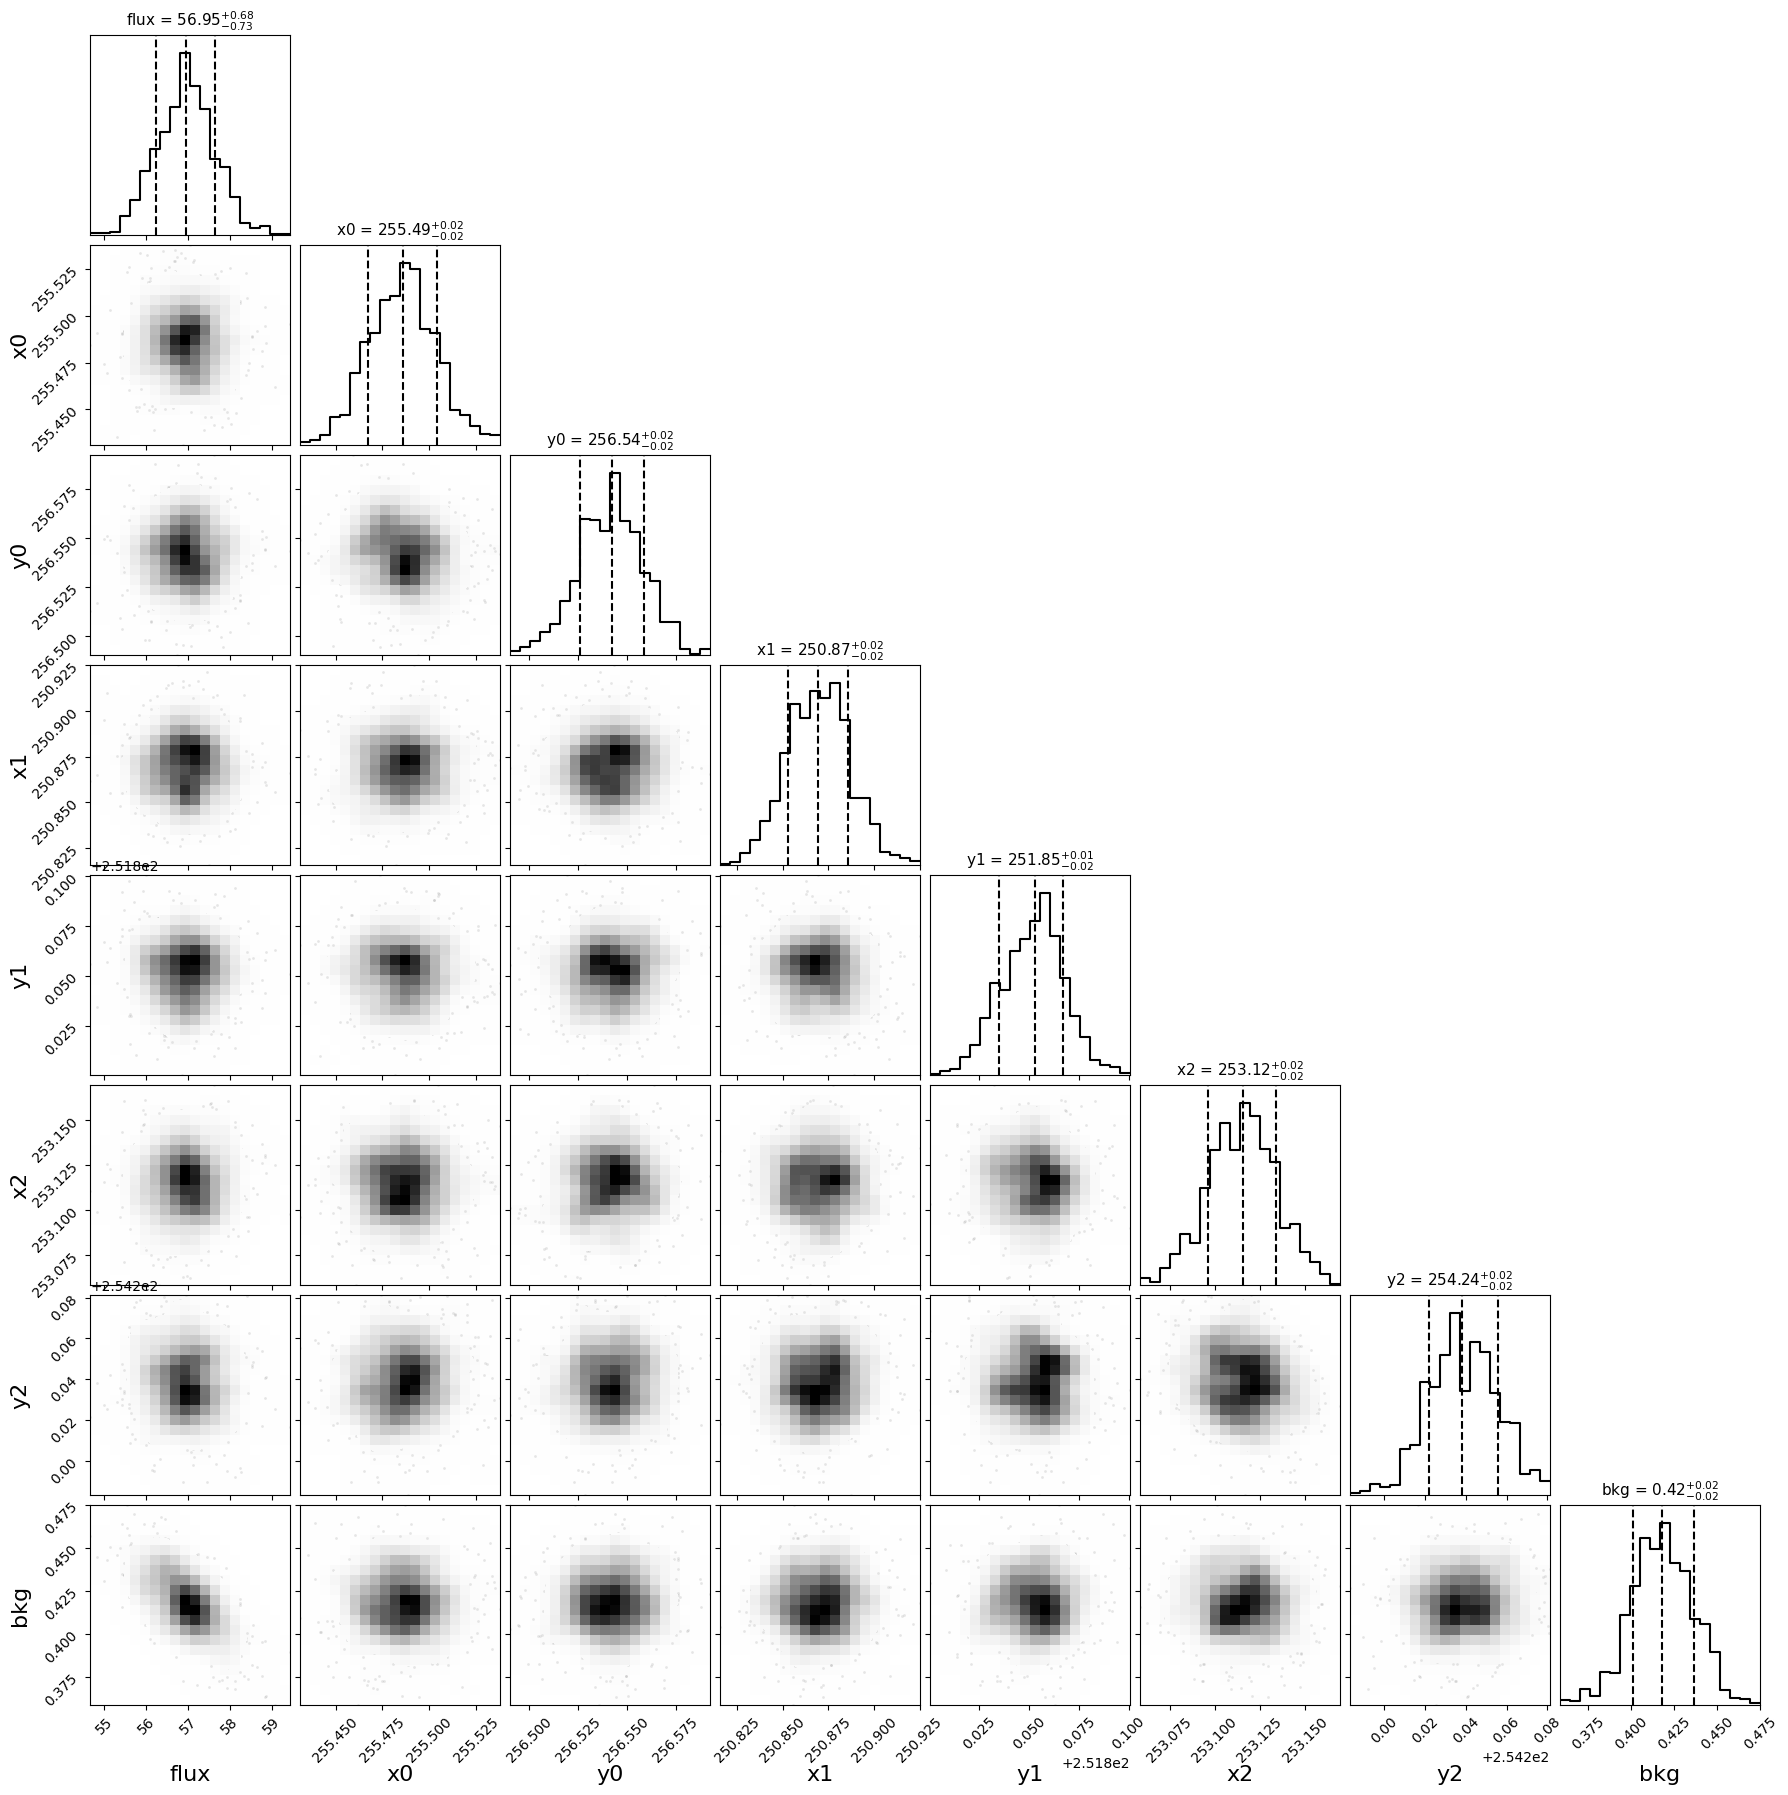

4 0.15813075896613155
4 0.15813075896613155
4 0.15813075896613155
      pos_x              pos_y             aper_bkg         aperture_sum   ... aper_sum_corrected  aper_sum_bkgsub     annulus_median          exp        
------------------ ------------------ ------------------ ----------------- ... ------------------ ----------------- ------------------- ------------------
255.66244104159586  254.6870255481229  3.782845308839669  77.7718646507189 ...  98.46126991386338 73.98901934187923  0.0752573162317276 iebc16ubq_flc.fits
 250.9814775384698 250.05069819362694  3.757923925895466 77.76012403445931 ...  98.47881028725593 74.00220010856384  0.0747615210711956 iebc16u5q_flc.fits
253.32203705670904  252.3689396762377 3.5423415766081483 78.50894782758718 ...  99.76219874596985 74.96660625097903 0.07047264650464058 iebc16u8q_flc.fits


In [1]:
from photutils.psf import EPSFModel
from astropy.coordinates import SkyCoord
from astropy import units as u
import sys,glob
sys.path.append('/Users/jpierel/CodeBase/st_phot')
import st_phot
from st_phot.photometry import observation
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.table import vstack
import sys
sys.path.append('/Users/jpierel/CodeBase/wfc3_photometry')
from psf_tools.PSFUtils import make_models
from psf_tools.PSFPhot import get_standard_psf

pam = fits.open('/Users/jpierel/DataBase/HST/UVIS2wfc3_map.fits')[1].data
pams = {'C': pam[:512, :513], 'D': pam[:512, -513:]}
pam = pams['C']
all_phot = None
import numpy as np
import astropy
from astropy import wcs

ra,dec = ['17:35:44.3371','+4:49:56.883']
sky_location = SkyCoord(ra,dec,unit=(u.hourangle,u.deg))
imwcs = wcs.WCS(fits.open(glob.glob('example_data/*flc.fits')[0])['SCI',1].header,
               fits.open(glob.glob('example_data/*flc.fits')[0]))
y,x = astropy.wcs.utils.skycoord_to_pixel(sky_location,imwcs)

grid = make_models(get_standard_psf('/Users/jpierel/DataBase/HST/psfs','F814W','UVIS'))[0]
grid.x_0 = x
grid.y_0 = y
psf_width=21
yg, xg = np.mgrid[-1*(psf_width-1)/2:(psf_width+1)/2,-1*(psf_width-1)/2:(psf_width+1)/2].astype(int)
yf, xf = yg+int(y+.5), xg+int(x+.5)

psf = np.array(grid(xf,yf)).astype(float)
epsf_model = EPSFModel(psf,origin=(10,10))

hst_obs = observation(glob.glob('example_data/*flc.fits'),pam)

hst_obs.psf_photometry(epsf_model,sky_location=sky_location,bounds={'flux':[-3000,100],'centroid':[-1,1],'bkg':[0,1]},
                       fit_width=5,maxiter=None,npoints=100,fit_centroid='pixel',fit_bkg=True,background=None,
                       use_MLE=True)
hst_obs.plot_psf_fit()
plt.show()
print(hst_obs.psf_result.phot_cal_table)

hst_obs.plot_psf_posterior(minweight=.0005)
plt.show()


hst_obs.aperture_photometry(sky_location,radius=4)
print(hst_obs.aperture_result.phot_table)